# Implementation and Evaluation of the von Heijne Algorithm with PSWM


In [3]:
# ! pip install -q import-ipynb
# ! pip install -q scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: C:\Users\utente\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: C:\Users\utente\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import import_ipynb
from create_pswm import get_pswm
import math
import numpy as np
import seaborn as sns
import sklearn.metrics as skl
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
def algorithm_vonheijne(matrix , df): 
    
    # Iterate among all sequences of the set 
    
    validation_complete = []    # List that contains all the scores as well as additional informations
    validation_scores = []      # List that only contains the scores
    
    for _ , row in df.iterrows():

        seq = row["Sequence"]   # Extract the sequence from the dataframe
        pos = 0                 # Counter for window size tracking
        aa = 0                  # Index that moves along the sequence
        tmp_score = 0           # Initialize window score
        max_window_score = -math.inf , 0 , 0 , "seq" # Initialize a variable that keeps in memory only the best window 
        
        end = min(90, len(seq)) # We end iterating on the sequence when we reach the 90th aa or when the 
                                # sequence ends (sequence length < 90 aa)
        
        while aa < end - 14:    # Iteration on the sequence
            while pos <= 14:    # Iteration while the window is less than the fixed window size
                
                try:            # Try statement to handle aminoacids not found in the matrix
                    tmp_score += matrix[seq[aa + pos]][pos] # computing the score of the window
                    
                except KeyError :
                    tmp_score += 0
                pos +=1         # Increasing the window size counter
                
            if tmp_score > max_window_score[0]: # Checking if the actual window has a better score than the previous one
                max_window_score = tmp_score, aa, aa + pos, seq[aa:aa + pos]
            
            aa += 1             # Increase the starting point
            pos = 0             # Reset the window size
            tmp_score = 0       # Reset window score
 
            
        validation_scores.append(max_window_score[0])
        validation_complete.append(max_window_score)
        
    return validation_complete , validation_scores

In [6]:
def class_vector(df_obs): # Function that creates a class vector for all the sequences in a dataset given the index
    class_list = []
    
    for _ , row in df_obs.iterrows():
        
        if row["Class"] == "Negative":
            class_list.append(0)
            
        else:             # If row["Class"] == "Positive"
            class_list.append(1)
            
    return class_list

In [7]:
def best_threshold(validation_class , validation_scores , test_class , test_scores ):  

    # index --> index of the test set
    # validation_class --> classes observed in the validation set
    # validation_scores --> scores computed on the validation set

    # best_treshold --> best threshold according to the validation set
    
    # test_scores --> scores computed on the test set
    # test_class --> classes observed in the test set
    
    
    precision, recall, thresholds = precision_recall_curve(validation_class, validation_scores)
    f_score = np.divide(
        2 * precision * recall,
        precision + recall,
        out=np.zeros_like(precision, dtype=float),
        where=(precision + recall) != 0
        )
    
    index_th = np.argmax(f_score)
    best_threshold = thresholds[index_th]
    predicted_class = [int( score >= best_threshold) for score in test_scores]

    # Return the list that contains the predicted classes of the test_set
    return predicted_class, precision, recall, thresholds, index_th, best_threshold



In [8]:
def metrics(pswm, validation, test):

    obs_validation = class_vector(validation)
    val_scores , val_scores_only = algorithm_vonheijne(pswm, validation)   # Validation scores and binary classification
    obs_test = class_vector(test)
    test_scores, test_scores_only = algorithm_vonheijne(pswm, test)        # Test scores and binary classification
    
    predicted_class_test, precision, recall, thresholds, index_th, best_thr = best_threshold(obs_validation, val_scores_only, obs_test, test_scores_only)


    MCC = skl.matthews_corrcoef(obs_test, predicted_class_test)            # Matthews Correlation Coefficient
    ACC = skl.accuracy_score(obs_test, predicted_class_test)               # Accuracy
    PPV = skl.precision_score(obs_test, predicted_class_test)              # Precision
    SEN = skl.recall_score(obs_test, predicted_class_test)                 # Recall
    CONF =skl.confusion_matrix(obs_test , predicted_class_test)            # Confusion Matrix

    # Heatmap plot

    # LAYOUT
    fig = plt.figure(figsize=(28, 8))
    gs_master = gridspec.GridSpec(1, 3, width_ratios=[2.5, 2.5, 1])

    # to center the third plot, we create a subgrid and put the plot in the middle
    gs_right = gs_master[0, 2].subgridspec(3, 1, height_ratios=[1, 2, 1])  # the central one is bigger

    # Subplot
    ax_pswm = fig.add_subplot(gs_master[0, 0])
    ax_pr   = fig.add_subplot(gs_master[0, 1])
    ax_conf = fig.add_subplot(gs_right[1])   # vertical


    # HEATMAP PSWM
    matrix = pd.DataFrame(pswm)
    sns.heatmap(
        matrix.T,
        annot=True,
        cbar=True,
        cmap="icefire",
        cbar_kws={'label': 'Log2 frequencies'},
        ax=ax_pswm
    )
    ax_pswm.set_title("Heatmap pswm matrix")
    ax_pswm.set_yticklabels(ax_pswm.get_yticklabels(), rotation=0)

    # PRECISION–RECALL CURVE
    df_rec_prec = pd.DataFrame({"Recall": recall, "Precision": precision})
    plot= sns.lineplot(data=df_rec_prec, x="Recall", y="Precision", label="PR curve", ax=ax_pr)

    # Best threshold point
    ax_pr.scatter(
        recall[index_th + 1],
        precision[index_th + 1],
        s=80, zorder=5, label=f"Best thr = {best_thr:.4f}"
    )
    ax_pr.grid(True, linestyle="--", alpha=1)
    ax_pr.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision–Recall curve with best threshold")

    # CONFUSION MATRIX 
    sns.heatmap(
        CONF,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        ax=ax_conf,
        vmax = 178
    )
    ax_conf.set_title("Confusion Matrix")
    ax_conf.set_xlabel("Predicted")
    ax_conf.set_ylabel("Observed")

    # Migliora la disposizione
    plt.tight_layout()
    plt.show()


    
    return MCC, ACC, PPV, SEN, CONF ,index_th, recall, precision, df_rec_prec, best_thr, plot

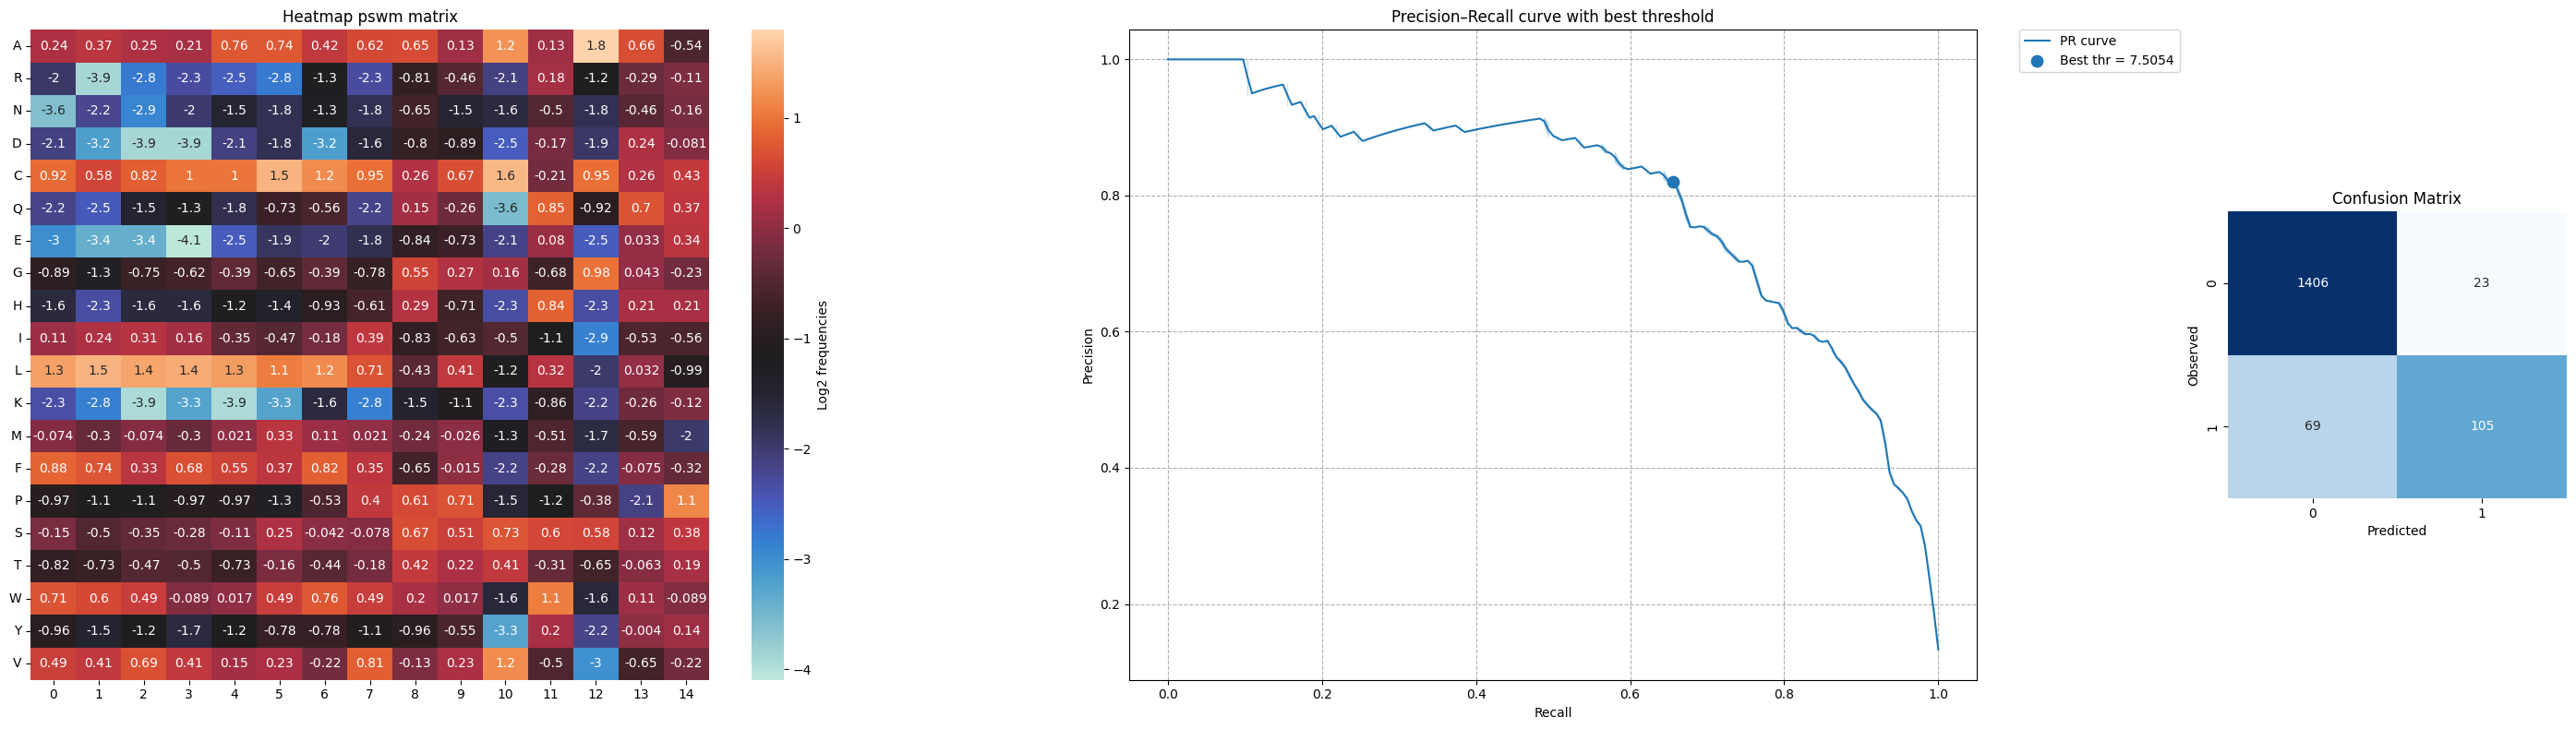

MCC = 0.6740451871666213
Accuracy = 0.9426076107298814
Precision = 0.8203125
Sensitivity = 0.603448275862069
Confusion Matrix = [[1406   23]
 [  69  105]]




In [9]:
# TEST CELL : metrics

if __name__ == "__main__":
    
    metrics_name = ["MCC", "Accuracy", "Precision", "Sensitivity" , "Confusion Matrix"]
#../Data_Preparation/
    df=pd.read_csv("train_bench.tsv", sep="\t")
    
    df_pos=df.query("Class=='Positive' and (Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5')")   # Recover a training set
                                                         
    df_validation=df.query("Set=='1'")                   # Recover a validation set
    
    df_test=df.query("Set=='2'")                         # Recover a testing set
    
    matrix = get_pswm(df_pos,13,2)                       # Recover the pswm matrix
    
    stats=metrics(matrix,df_validation,df_test)          # Get the metrics

    for name, stat in zip(metrics_name,stats):
        print(f"{name} = {stat}")
        
    print("\n")
    
    
